In [1]:
import sys, os, pickle, time, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from array import array

import ROOT as rt
rt.TGaxis.SetMaxDigits(4)
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import ROOT.RooFit as rf
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from histo_utilities import create_TH1D, create_TH2D, SetMaxToMaxHist, std_color_list
from gridVarQ2Plot import col_dic, label_dic
from progressBar import ProgressBar
from categoriesDef import categories
from pT_calibration_reader import pTCalReader

from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [3]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [4]:
def computeB0pTweights(ds, cal_pT):
    # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
    w = cal_pT.f['C'](ds['MC_B_pt'])
    if np.sum(w==0):
        print np.sum(w==0)
        raise
    up = cal_pT.f['Up'](ds['MC_B_pt'])
    down = cal_pT.f['Down'](ds['MC_B_pt'])
    return w, up, down

In [5]:
df = {}
ptCal = {}
dsMu = DSetLoader('B0_MuNuDmst_PUc0')
wPt = {}
for cat in ['high']:
# for cat in ['low', 'mid', 'high']:
    ptCal[cat] = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.capitalize()))
    
    fn = '/'+cat.capitalize()+'_corr.root'
    df['MC'+cat] = pd.DataFrame(rtnp.root2array(dsMu.skimmed_dir+fn))
    wPt['MC'+cat] = computeB0pTweights(df['MC'+cat], ptCal[cat])
    
    df['RD'+cat] = pd.DataFrame(rtnp.root2array('../data/cmsRD/skimmed/B2DstMu_B0_200515_'+cat.capitalize()+'_corr.root'))

    dsTau = DSetLoader('B0_TauNuDmst_PUc0')
    df['MCtau'+cat] = pd.DataFrame(rtnp.root2array(dsTau.skimmed_dir+'/High_corr.root'))
    wPt['MCtau'+cat] = computeB0pTweights(df['MCtau'+cat], ptCal[cat])

In [6]:
s = '\n'.join([k for k in df['MChigh'].columns[1:]])
print(s)

q2
Est_mu
M2_miss
U_miss
mu_pt
mu_eta
mu_phi
mu_sigdxy
B_pt
B_eta
B_phi
Dst_pt
Dst_eta
Dst_phi
D0_pt
D0_eta
D0_phi
pi_pt
pi_eta
pi_phi
K_pt
K_eta
K_phi
pval_piK
sigdxy_vtxD0_PV
pis_pt
pis_eta
pis_phi
pval_D0pis
mass_piK
mass_D0pis
mass_D0pismu
pval_D0pismu
chi2_D0pismu
d_vtxD0pismu_PV
dxy_vtxD0pismu_PV
cos_D0pismu_PV
cosT_D0pismu_PV
N_goodAddTks
tkCharge_0
tkCharge_1
tkPt_0
tkPt_1
tkPtError_0
tkPtError_1
tkEta_0
tkEta_1
tkPhi_0
tkPhi_1
tkMassVis_0
tkMassVis_1
tkMassHad_0
tkMassHad_1
tkMassMuTk_0
tkMassMuTk_1
tkMassMiss2_0
tkMassMiss2_1
tkUmiss_0
tkUmiss_1
tkMassVis12
tkMassHad12
tkUmiss12
cat_low
cat_mid
cat_high
muPass_Mu12_IP6
muPass_Mu9_IP6
muPass_Mu7_IP4
N_vtx
localVertexDensity
MC_q2
MC_Est_mu
MC_M2_miss
MC_B_pt
MC_B_eta
MC_B_phi
MC_B_ctau
MC_Dst_pt
MC_Dst_eta
MC_Dst_phi
MC_mu_pt
MC_mu_eta
MC_mu_phi
MC_mu_TransvIP_PV
MC_mu_TransvIP_vtxDst
MC_mu_IP_vtxDst
MC_pi_pt
MC_pi_eta
MC_pi_phi
MC_K_pt
MC_K_eta
MC_K_phi
MC_pis_pt
MC_pis_eta
MC_pis_phi
MC_idxMatch
MC_muMotherPdgId
MC_munuSiste

In [7]:
def make_comp_plot_1D(inputs, #[x, label, color=-1 (auto), weights (None)]
                      transformX = None,
                      binning=[None, None, None],
                      setLog = '',
                      axis_title = ['', ''],
                      scale_histo = 'norm',
                      opt='overflow+underflow',
                      leg_loc=[0.6, 0.7, 0.9, 0.93] # x0, y0, w, h
                     ): 
    
    if not leg_loc is None:
        leg = rt.TLegend(leg_loc[0], leg_loc[1], leg_loc[0] + leg_loc[2], leg_loc[1] + leg_loc[3])
        leg.SetBorderSize(0)
        leg.SetFillStyle(0)
        
    colors = []
    for p in inputs:
        if len(p) > 2:
            colors.append(p[2])
        else:
            colors.append(-1)
    jStd = 0
    for i,c in enumerate(colors):
        if c == -1:
            colors[i] = std_color_list[jStd]
            jStd += 1
    
    hList = []
    for i, p in enumerate(inputs):
        if transformX is None:
            x = p[0]
        else:
            x = transformX(p[0])
        label = p[1]
        w = p[3] if len(p) > 3 else None
        h = create_TH1D(x, weights=w,
                        binning=binning if i==0 else hList[0].binning, 
                        axis_title=axis_title,
                        scale_histo=scale_histo, opt=opt,
                       )
        h.SetLineColor(colors[i])
        if not leg_loc is None:
            leg.AddEntry(h, label, 'lp')
        hList.append(h)
            
    m = SetMaxToMaxHist(hList)
    c = drawOnCMSCanvas(CMS_lumi, hList, 'same')
    leg.Draw()
    
    if 'x' in setLog: c.SetLogx()
    if 'y' in setLog: c.SetLogy()
    
    c.dnd = [hList, leg]
    return c

# General plots

In [8]:
txt = rt.TLatex()
txt.SetTextSize(0.04)
txt.SetTextFont(42)

In [27]:
ctau = df['MChigh']['MC_B_ctau']
t0 = 0.457
t1 = 0.455 + 3*0.008
wCtau = t0/t1 * np.exp(ctau * (1/t0 - 1/t1))

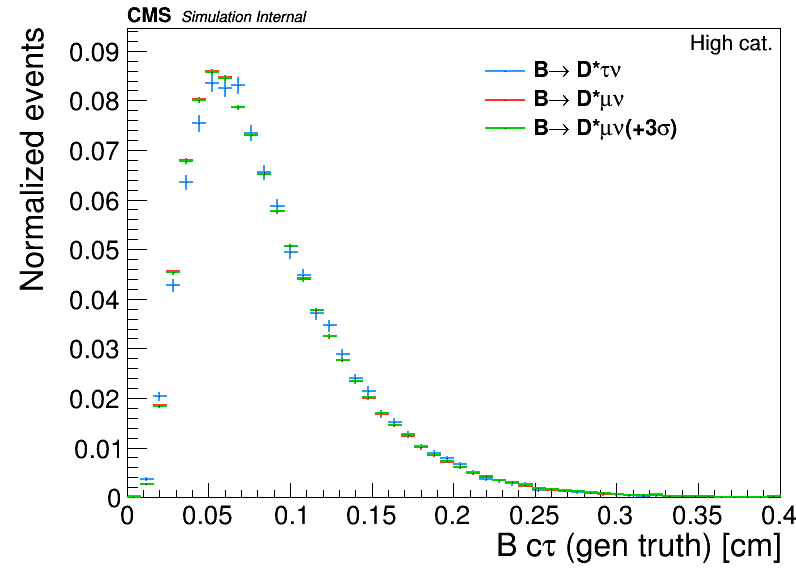

In [32]:
make_comp_plot_1D(
    [
        [df['MCtauhigh']['MC_B_ctau'], label_dic['tau']],
        [df['MChigh']['MC_B_ctau'], label_dic['mu']], 
        [df['MChigh']['MC_B_ctau'], label_dic['mu'] + '(+3#sigma)', -1, wCtau],
    ],
#     transformX = lambda x: 10*np.abs(x),
#     binning=np.logspace(-6, 1, 70), setLog='x',
    binning=[50, 0, 0.4],
    axis_title = ['B c#tau (gen truth) [cm]', 'Normalized events'],
    leg_loc=[0.6, 0.75, 0.28, 0.15]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'High cat.')

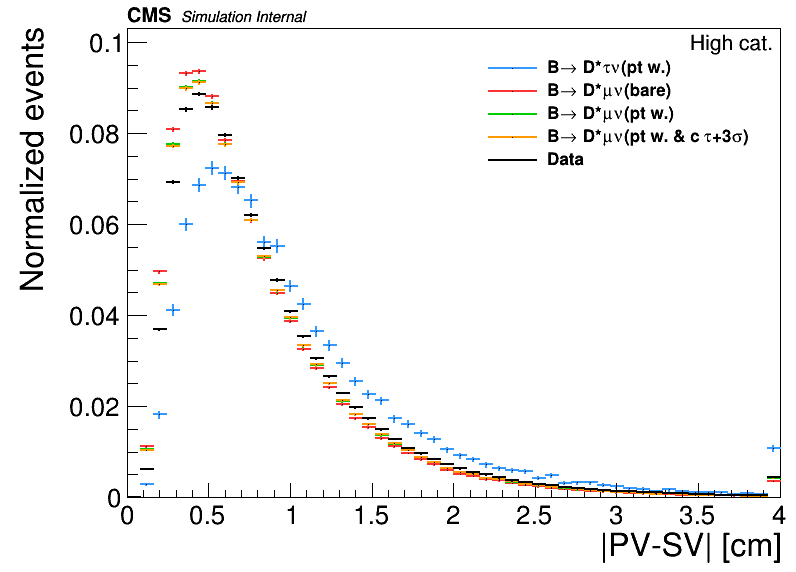

In [31]:
make_comp_plot_1D(
    [
        [df['MCtauhigh']['d_vtxD0pismu_PV'], label_dic['tau'] + '(pt w.)', -1, wPt['MCtauhigh'][0]],
        [df['MChigh']['d_vtxD0pismu_PV'], label_dic['mu'] + '(bare)'],
        [df['MChigh']['d_vtxD0pismu_PV'], label_dic['mu'] + '(pt w.)', -1, wPt['MChigh'][0]],
        [df['MChigh']['d_vtxD0pismu_PV'], label_dic['mu'] + '(pt w. & c#tau+3#sigma)', -1, wPt['MChigh'][0]*wCtau],
        [df['RDhigh']['d_vtxD0pismu_PV'], label_dic['data'], 1],
        
    ],
#     transformX = lambda x: 10*np.abs(x),
#     binning=np.logspace(-6, 1, 70), setLog='x',
    binning=[50, 0, 4],
    axis_title = ['|PV-SV| [cm]', 'Normalized events'],
    leg_loc=[0.6, 0.7, 0.35, 0.2]
)

txt.SetTextAlign(33)
txt.DrawLatexNDC(0.97, 0.94, 'High cat.')